In [272]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import torch
import random
device = 'cuda' if torch.cuda.is_available() else 'cpu'
from scipy.ndimage import gaussian_filter
import sys
from tqdm import tqdm
from functools import partial
import acd
from copy import deepcopy
sys.path.append('..')
sys.path.append('../..')
from transforms_torch import bandpass_filter
# plt.style.use('dark_background')
sys.path.append('../../dsets/mnist')
import dset
from model import Net, Net2c
from util import *
from numpy.fft import *
from torch import nn
from style import *
from captum.attr import (
    InputXGradient,
    Saliency,
    GradientShap,
    DeepLift,
    DeepLiftShap,
    IntegratedGradients,
    LayerConductance,
    NeuronConductance,
    NoiseTunnel,
)
import pickle as pkl
from torchvision import datasets, transforms
from sklearn.decomposition import NMF
from transform_wrappers import *
import visualize as viz
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split
from skorch import NeuralNetClassifier

device = 'cuda'

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [312]:
np.random.seed(13)
torch.manual_seed(13)
class p:
    n = 50000
    p = 100
idx_zero = 12
window = 0
X = np.random.randn(p.n, p.p).astype(np.float32)
X_t = torch.rfft(torch.Tensor(X), signal_ndim=1)

# define y
band = X_t[:, idx_zero - window: idx_zero + window + 1]
band_mag = torch.pow(band[..., 0]**2 + band[..., 1]**2, 0.5)
band_mag_mean = torch.mean(band_mag, axis=1)
thresh = np.nanpercentile(band_mag_mean, 50)
y = (band_mag_mean > thresh).cpu().detach().numpy().astype(np.int)

# data split
X_train, X_test, y_train, y_test = train_test_split(X, y)

In [313]:
class FNN(nn.Module):
    def __init__(self, p):
        super(FNN, self).__init__()
        self.fc1 = nn.Linear(p, 100)
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(100, 2)
        self.use_softmax = True

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu1(x)
        x = self.fc2(x)
        if self.use_softmax:
            x = F.softmax(x, dim=1)
        return x
    
net = NeuralNetClassifier(
    FNN(p=p.p),
    max_epochs=10,
    lr=0.1,
    # Shuffle training data on each epoch
    iterator_train__shuffle=True,
    train_split=None,
)
net.fit(X_train, y_train)
print('test acc', net.score(X_test, y_test))

  epoch    train_loss     dur
-------  ------------  ------
      1        0.6925  0.6142
      2        0.5059  0.6074
      3        0.2218  0.6034
      4        0.1602  0.5990
      5        0.1330  0.5971
      6        0.1166  0.5999
      7        0.1055  0.6007
      8        0.0958  0.6059
      9        0.0874  0.6067
     10        0.0808  0.6057
test acc 0.95216


In [314]:
def modularize(f):
    class Transform(nn.Module):
        def __init__(self, f):
            super(Transform, self).__init__()
            self.f = f
        def forward(self, x):
            return self.f(x)
    return Transform(f)
        

In [315]:
mod = modularize(lambda x: torch.irfft(x, signal_ndim=1)[:, :-1])
mt = Net_with_transform(model=net.module_, transform=mod).to(device)

In [316]:
x_torch = torch.Tensor(X_test[0].reshape(1, -1))
x_t = torch.rfft(x_torch, signal_ndim=1).to(device)
print('shapes', x_t.shape)
mt(x_t)

shapes torch.Size([1, 51, 2])


tensor([[9.9914e-01, 8.5541e-04]], device='cuda:0', grad_fn=<SoftmaxBackward>)

In [317]:
mod(x_t).shape

torch.Size([1, 100])

In [318]:
x_torch = torch.Tensor(X_test[0].reshape(1, -1))
x_t = torch.rfft(x_torch, signal_ndim=1)
print(x.shape, x_t.shape)
sweep_dim = 1
tiles = acd.tiling_2d.gen_tiles(x_t, fill=0, method='cd', sweep_dim=sweep_dim)
tiles = np.repeat(np.expand_dims(tiles, axis=-1), repeats=2, axis=3).squeeze()
x_t = x_t.squeeze()
print('tiles shape', tiles.shape)
scores = acd.get_scores_2d(mt, method='cd', ims=tiles, im_torch=x_t)[:, 1]

(1, 100) torch.Size([1, 51, 2])
tiles shape (51, 51, 2)


In [319]:
# mods = list(mt.modules())
# for i, mod in enumerate(mods):
#     t = str(type(mod))
#     print(t, 'modularize' in t and 'Transform' in t)

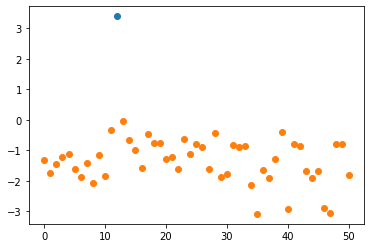

In [320]:
d = scores.size
idxs = np.zeros(d).astype(bool)
idxs[idx_zero - window: idx_zero + window + 1] = 1
plt.plot(np.arange(d)[idxs], scores[idxs], 'o')
plt.plot(np.arange(d)[~idxs], scores[~idxs], 'o')
plt.show()